In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import os
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



# Create a directory to save images if it doesn't exist

# Load the dataset
file_path = 'data/Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv'
data = pd.read_csv(file_path)

# Step 1: Dropping irrelevant columns
columns_to_drop = ['Data_Value_Unit', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 
                   'ClassID', 'TopicID', 'QuestionID', 'DataValueTypeID', 'LocationID', 
                   'StratificationCategoryId1', 'StratificationID1', 'GeoLocation', 'Data_Value_Alt', 'Datasource', 'LocationAbbr']

# Get the number of rows (records) in the file
number_of_records = data.shape[0]
print(f"\nThe file contains {number_of_records} records.\n")

# Drop irrelevant columns
cleaned_data = data.drop(columns=columns_to_drop)

# Step 2: Filtering the data to only include records related to obesity
# We are focusing on rows where the 'Class' column is related to "Obesity / Weight Status"
cleaned_data = cleaned_data[cleaned_data['Class'] == 'Obesity / Weight Status']

# Optional: Print out how many records are related to obesity
number_of_obesity_records = cleaned_data.shape[0]
print(f"\nThe dataset contains {number_of_obesity_records} records related to obesity.\n")

# Drop the 'Class' column since it's no longer needed after filtering
cleaned_data = cleaned_data.drop(columns=['Class'])

# Step 3: Checking for missing values before cleaning
missing_values = cleaned_data.isnull().sum()
print("Missing values before cleaning:\n", missing_values)

# Step 4: Filling missing values in categorical columns with mode
categorical_cols = ['Age(years)', 'Education', 'Gender', 'Income', 'Race/Ethnicity']

for col in categorical_cols:
    cleaned_data[col] = cleaned_data[col].fillna(cleaned_data[col].mode()[0])

# Step 5: Dropping rows with missing Data_Value (target variable)
cleaned_data = cleaned_data.dropna(subset=['Data_Value'])

# Step 6: Checking for missing values after cleaning
missing_values_after = cleaned_data.isnull().sum()
print("\nMissing values after cleaning:\n", missing_values_after)

# Optional: Checking the structure of the cleaned data
print("\nCleaned Data Information:\n")
print(cleaned_data.info())




The file contains 93249 records.


The dataset contains 36234 records related to obesity.

Missing values before cleaning:
 YearStart                      0
YearEnd                        0
LocationDesc                   0
Topic                          0
Question                       0
Data_Value_Type                0
Data_Value                  3554
Low_Confidence_Limit        3554
High_Confidence_Limit       3554
Sample_Size                 3554
Total                      34940
Age(years)                 28470
Education                  31058
Gender                     33646
Income                     27176
Race/Ethnicity             25882
StratificationCategory1        2
Stratification1                2
dtype: int64

Missing values after cleaning:
 YearStart                      0
YearEnd                        0
LocationDesc                   0
Topic                          0
Question                       0
Data_Value_Type                0
Data_Value                     0
Low_

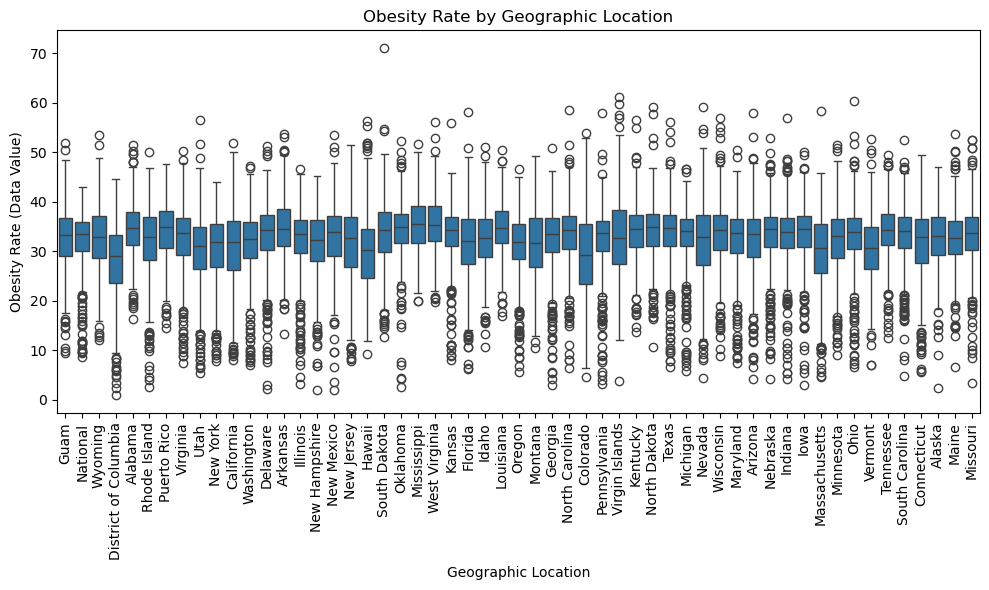

Images saved in folder: images/


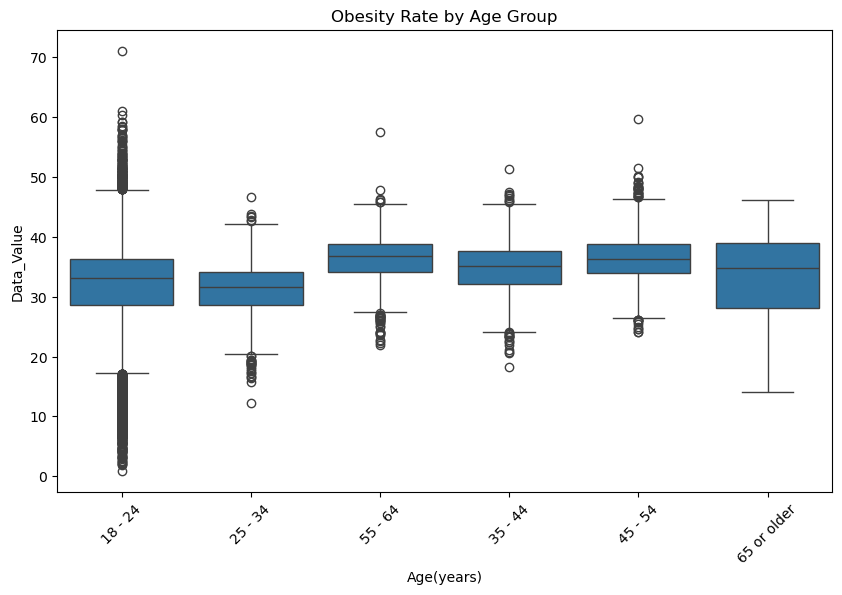

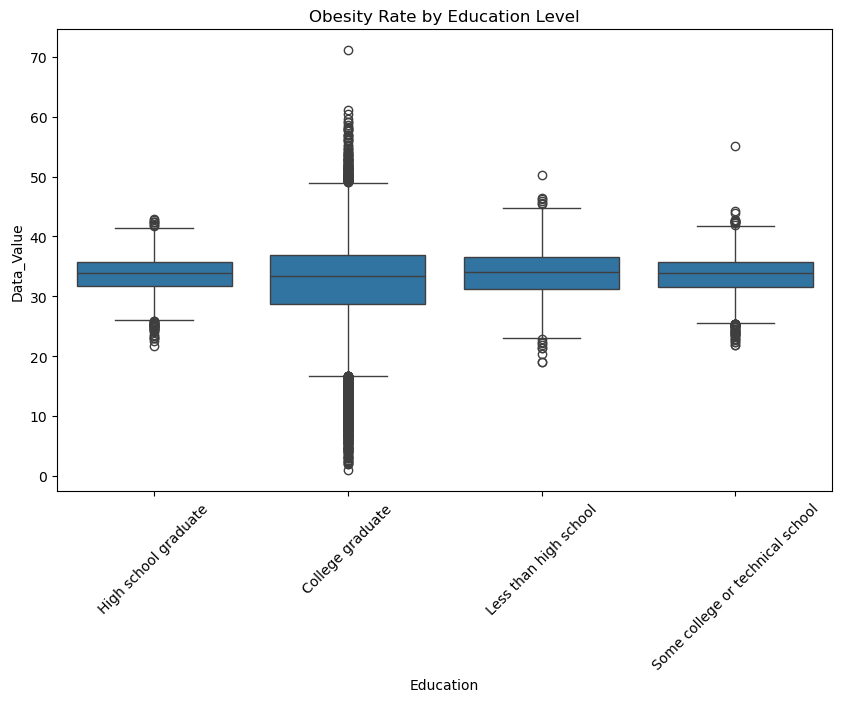

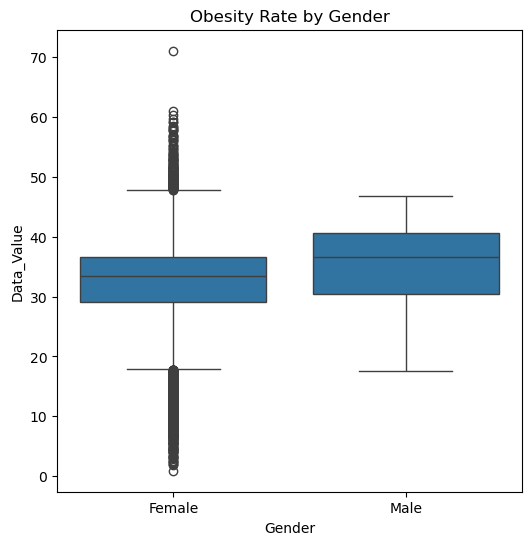

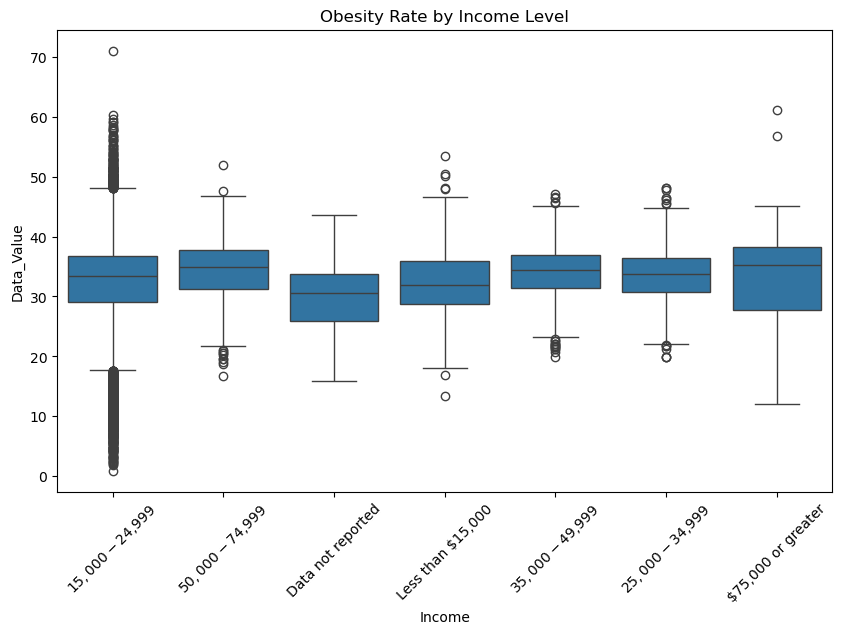

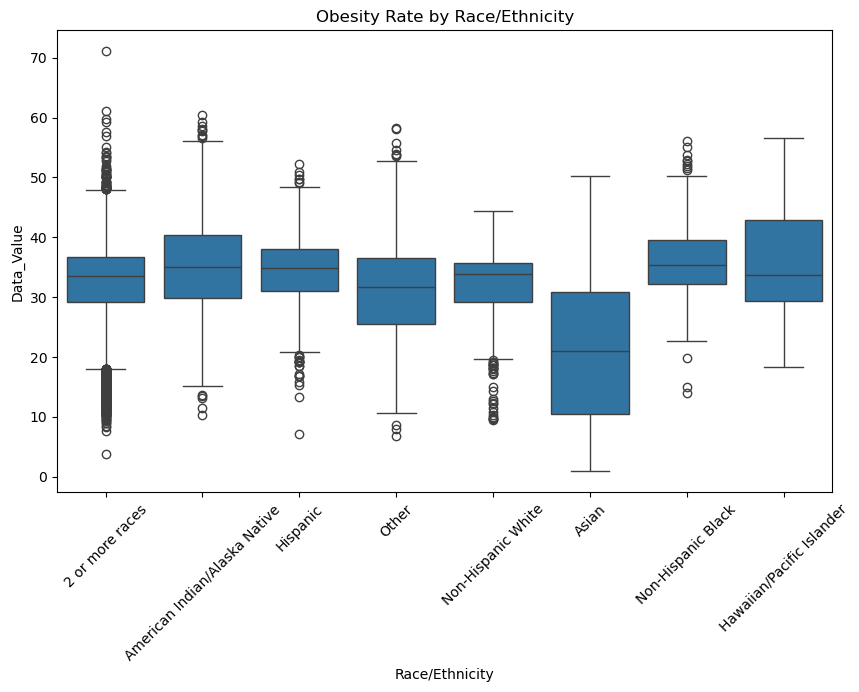

In [2]:
# Define the folder path where images will be saved
save_path = "images/"

# Obesity by Geographic Location (e.g., LocationDesc)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_data, x='LocationDesc', y='Data_Value')
plt.title('Obesity Rate by Geographic Location')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Geographic Location')
plt.ylabel('Obesity Rate (Data Value)')
plt.tight_layout()  # Adjust layout for better display
plt.savefig(f"{save_path}obesity_by_location.png")
plt.show()



# Obesity by Age
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_data, x='Age(years)', y='Data_Value')
plt.title('Obesity Rate by Age Group')
plt.xticks(rotation=45)
plt.savefig(f"{save_path}obesity_by_age.png")

# Obesity by Education Level
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_data, x='Education', y='Data_Value')
plt.title('Obesity Rate by Education Level')
plt.xticks(rotation=45)
plt.savefig(f"{save_path}obesity_by_education.png")

# Obesity by Gender
plt.figure(figsize=(6, 6))
sns.boxplot(data=cleaned_data, x='Gender', y='Data_Value')
plt.title('Obesity Rate by Gender')
plt.savefig(f"{save_path}obesity_by_gender.png")

# Obesity by Income Level
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_data, x='Income', y='Data_Value')
plt.title('Obesity Rate by Income Level')
plt.xticks(rotation=45)
plt.savefig(f"{save_path}obesity_by_income.png")

# Obesity by Race/Ethnicity
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_data, x='Race/Ethnicity', y='Data_Value')
plt.title('Obesity Rate by Race/Ethnicity')
plt.xticks(rotation=45)
plt.savefig(f"{save_path}obesity_by_race_ethnicity.png")

print(f"Images saved in folder: {save_path}")


Obese
1    23187
0     9493
Name: count, dtype: int64


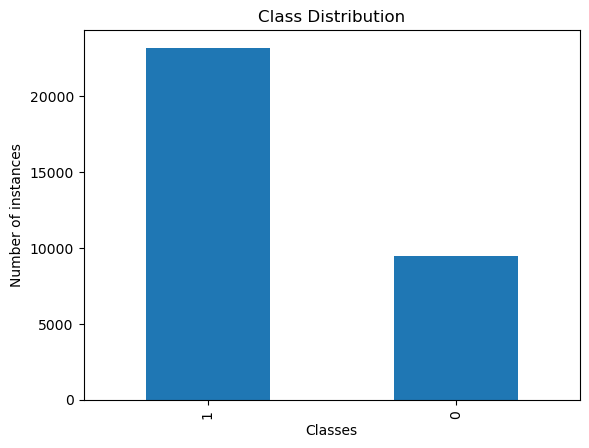

<Figure size 640x480 with 0 Axes>

In [3]:

# Create a directory to save images if it doesn't exist
save_path = 'images/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Selecting the feature columns (assuming these are in your dataset)
features = ['Age(years)', 'Education', 'Gender', 'Income', 'Race/Ethnicity', 'LocationDesc']

# Creating binary target variable 'Obese' (1 for obese, 0 for not obese)
cleaned_data['Obese'] = cleaned_data['Data_Value'].apply(lambda x: 1 if x >= 30 else 0)

# Encoding categorical variables
label_encoders = {}
for col in features:
    le = LabelEncoder()
    cleaned_data[col] = le.fit_transform(cleaned_data[col])
    label_encoders[col] = le

# Splitting the data into features (X) and target (y)
X = cleaned_data[features]
y = cleaned_data['Obese']  # Binary target for classification

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (70% training, 30% testing)
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Assuming your target variable is stored in 'y'
class_distribution = y.value_counts()

# Display class distribution
print(class_distribution)

# Optional: Plot the distribution for a clearer view
import matplotlib.pyplot as plt
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of instances')
plt.show()
plt.savefig(f"{save_path}class_distribution.png")



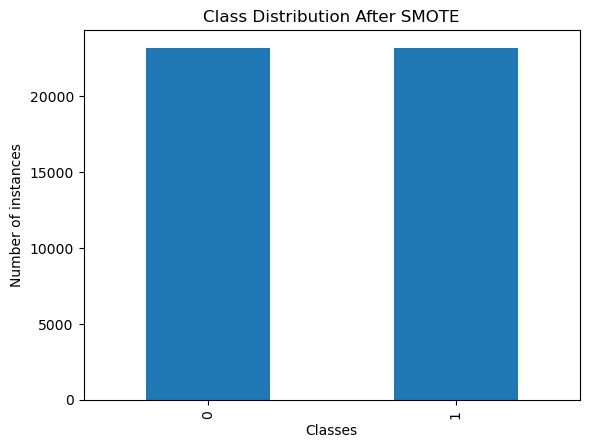

<Figure size 640x480 with 0 Axes>

In [4]:

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE for class imbalance handling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Checking the new class distribution after SMOTE
class_distribution_resampled = pd.Series(y_resampled).value_counts()

# Plotting the new class distribution after SMOTE
class_distribution_resampled.plot(kind='bar')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Classes')
plt.ylabel('Number of instances')
plt.show()

# Saving the plot
plt.savefig(f"{save_path}class_distribution_after_smote.png")


Logistic Regression Results:
Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      6907
           1       0.65      0.48      0.55      7006

    accuracy                           0.61     13913
   macro avg       0.62      0.61      0.60     13913
weighted avg       0.62      0.61      0.60     13913


Logistic Regression Coefficients:
           Feature  Coefficient
1       Education     0.317000
0      Age(years)     0.313715
2          Gender     0.140180
4  Race/Ethnicity     0.129566
5    LocationDesc     0.065539
3          Income     0.058488

Decision Tree Results:
Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.82      0.74      6907
           1       0.77      0.60      0.68      7006

    accuracy                           0.71     13913
   macro avg       0.72      0.71      0.71     13913
weighted avg

<Figure size 1000x600 with 0 Axes>

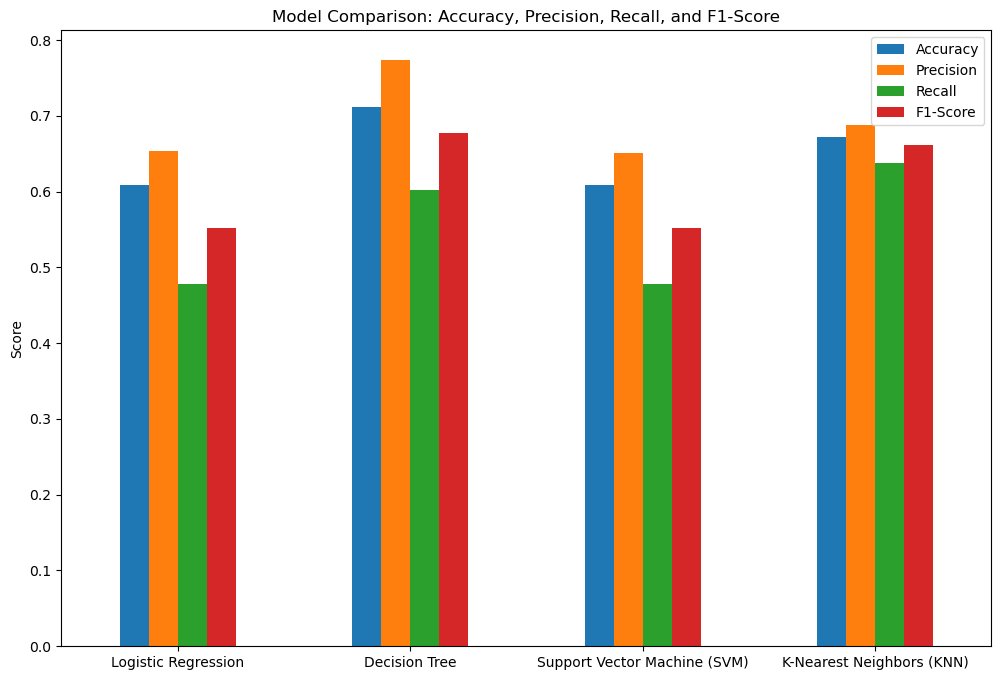

Images saved in folder: images/


In [5]:


# Create a directory to save images if it doesn't exist
save_path = 'images/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Train-test split (70% training, 30% testing) on resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Dictionary to store model performance metrics
model_metrics = {}

# Function to evaluate accuracy, precision, recall, F1-score and store in the dictionary
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store metrics in the dictionary
    model_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    # Print classification report
    print(f"{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Return trained model for further analysis
    return model

# Logistic Regression: Evaluate and extract coefficients
print("\nLogistic Regression Results:")
log_reg = LogisticRegression()  # Instantiate the logistic regression model
log_reg_trained = evaluate_model(log_reg, "Logistic Regression")

# Extract and display coefficients for Logistic Regression
log_reg_coef = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg_trained.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nLogistic Regression Coefficients:\n", log_reg_coef)

# Decision Tree Classifier: Evaluate and extract feature importances
print("\nDecision Tree Results:")
decision_tree = DecisionTreeClassifier()  # Instantiate the decision tree model
decision_tree_trained = evaluate_model(decision_tree, "Decision Tree")

# Extract and display feature importances for Decision Tree
tree_importance = pd.DataFrame({
    'Feature': features,
    'Importance': decision_tree_trained.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nDecision Tree Feature Importance:\n", tree_importance)

# Support Vector Machine (SVM): Evaluate and extract coefficients
print("\nSupport Vector Machine (SVM) Results:")
svm = SVC(kernel='linear')  # Instantiate the SVM model with a linear kernel
svm_trained = evaluate_model(svm, "Support Vector Machine (SVM)")

# Extract and display coefficients for SVM
svm_coef = pd.DataFrame({
    'Feature': features,
    'Coefficient': svm_trained.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nSupport Vector Machine (SVM) Coefficients:\n", svm_coef)

# K-Nearest Neighbors (KNN): Evaluate accuracy (no feature importances for KNN)
print("\nK-Nearest Neighbors (KNN) Results:")
knn = KNeighborsClassifier(n_neighbors=5)  # Instantiate the KNN model with 5 neighbors
evaluate_model(knn, "K-Nearest Neighbors (KNN)")

# Linear Regression: Predict continuous obesity rates (Data_Value)
y_continuous = cleaned_data['Data_Value']  # Using the continuous 'Data_Value' as target

# Train-test split for linear regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_scaled, y_continuous, test_size=0.3, random_state=42)

print("\nLinear Regression Results:")
linear_reg = LinearRegression()  # Instantiate the linear regression model
linear_reg.fit(X_train_reg, y_train_reg)

# Extract and display coefficients for Linear Regression
linear_reg_coef = pd.DataFrame({
    'Feature': features,
    'Coefficient': linear_reg.coef_
}).sort_values(by='Coefficient', ascending=False)
print("\nLinear Regression Coefficients:\n", linear_reg_coef)


# Plotting the metrics for each classification model
metrics_df = pd.DataFrame(model_metrics).T  # Convert dictionary to DataFrame

# Plotting the metrics using seaborn
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Comparison: Accuracy, Precision, Recall, and F1-Score')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.savefig(f"{save_path}model_comparison.png")  # Save the metrics bar plot
plt.show()

print(f"Images saved in folder: {save_path}")



Tuning Decision Tree...
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.82      0.74      6907
           1       0.77      0.60      0.68      7006

    accuracy                           0.71     13913
   macro avg       0.72      0.71      0.71     13913
weighted avg       0.72      0.71      0.71     13913


Tuning K-Nearest Neighbors (KNN)...
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Tuned K-Nearest Neighbors (KNN) Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      6907
           1       0.71      0.65      0.68      7006

    accuracy                           0.69     13913
   macro avg       0.69      0.69      0.69     13913
weighted avg       0.69      0.69      0.69   

<Figure size 1000x600 with 0 Axes>

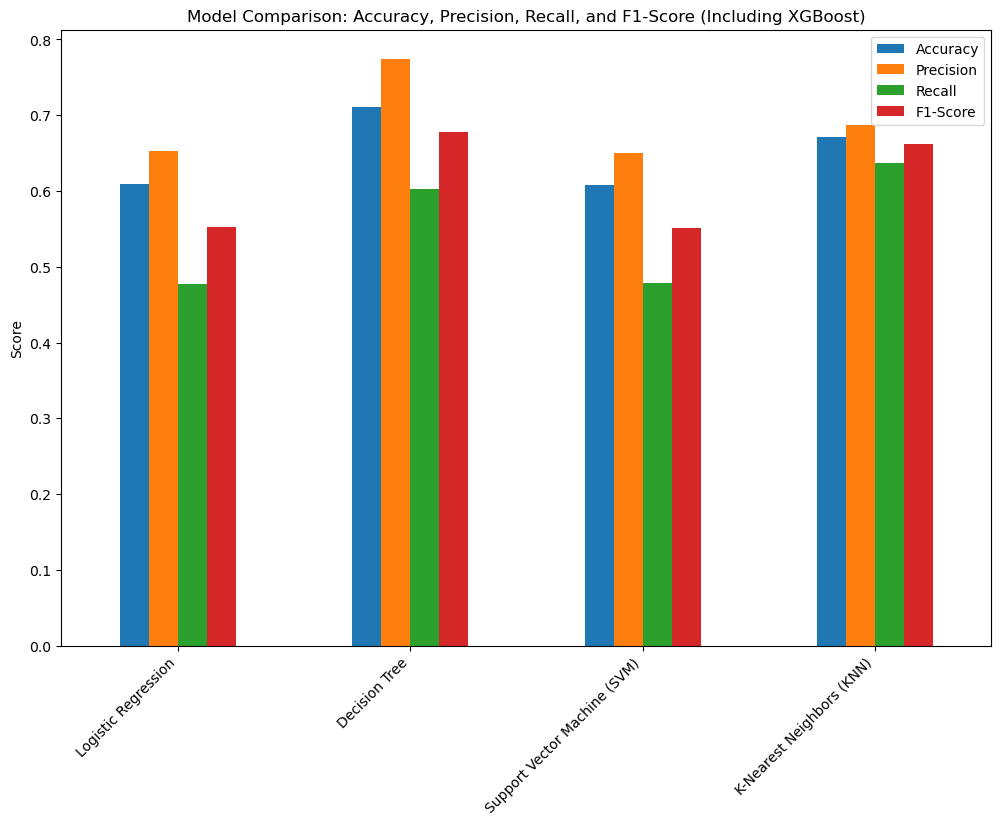

Images saved in folder: images/


In [6]:
from sklearn.model_selection import GridSearchCV

# 1. Decision Tree Tuning
print("\nTuning Decision Tree...")

# Define parameter grid for Decision Tree
decision_tree_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the Decision Tree Classifier
decision_tree_tuned = GridSearchCV(DecisionTreeClassifier(), decision_tree_params, cv=5, scoring='accuracy')
decision_tree_tuned.fit(X_train, y_train)

# Best parameters and results
print(f"Best parameters for Decision Tree: {decision_tree_tuned.best_params_}")
best_decision_tree = decision_tree_tuned.best_estimator_

# Evaluate tuned Decision Tree
model_tuned_dt = evaluate_model(best_decision_tree, "Tuned Decision Tree")

# 2. K-Nearest Neighbors Tuning
print("\nTuning K-Nearest Neighbors (KNN)...")

# Define parameter grid for KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the KNN Classifier
knn_tuned = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_tuned.fit(X_train, y_train)

# Best parameters and results
print(f"Best parameters for KNN: {knn_tuned.best_params_}")
best_knn = knn_tuned.best_estimator_

# Evaluate tuned KNN
model_tuned_knn = evaluate_model(best_knn, "Tuned K-Nearest Neighbors (KNN)")

# Compare Performance
# Plotting the updated metrics using seaborn
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Comparison: Accuracy, Precision, Recall, and F1-Score (Including XGBoost)')
plt.ylabel('Score')

# Rotate the x-axis labels and adjust alignment
plt.xticks(rotation=45, ha='right')

# Save and show the plot
plt.savefig(f"{save_path}model_comparison_with_xgboost.png")  # Save the updated metrics bar plot
plt.show()

print(f"Images saved in folder: {save_path}")



RandomForest Classifier Results:
RandomForest Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.73      6907
           1       0.76      0.61      0.68      7006

    accuracy                           0.71     13913
   macro avg       0.72      0.71      0.71     13913
weighted avg       0.72      0.71      0.71     13913


RandomForest Feature Importance:
           Feature  Importance
5    LocationDesc    0.572184
0      Age(years)    0.140388
4  Race/Ethnicity    0.109763
3          Income    0.085819
1       Education    0.073599
2          Gender    0.018247


<Figure size 1000x600 with 0 Axes>

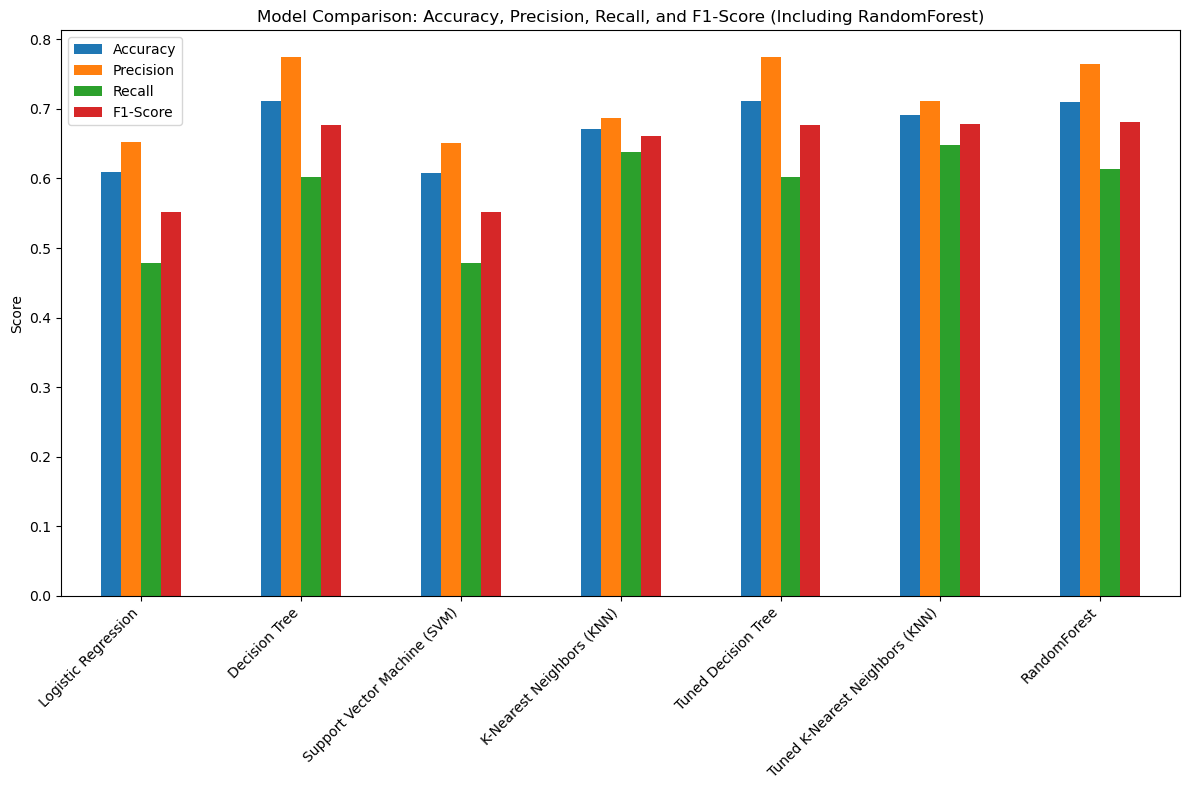

In [7]:
# RandomForest Classifier: Evaluate and extract feature importances
print("\nRandomForest Classifier Results:")
random_forest = RandomForestClassifier(random_state=42)  # Instantiate the RandomForest model

# Evaluate the model (assuming evaluate_model returns only the model)
random_forest_trained = evaluate_model(random_forest, "RandomForest")

# Ensure RandomForest metrics are added to model_metrics
model_metrics["RandomForest"] = {
    'Accuracy': accuracy_score(y_test, random_forest_trained.predict(X_test)),
    'Precision': precision_score(y_test, random_forest_trained.predict(X_test)),
    'Recall': recall_score(y_test, random_forest_trained.predict(X_test)),
    'F1-Score': f1_score(y_test, random_forest_trained.predict(X_test))
}

# Extract and display feature importances for RandomForest
forest_importance = pd.DataFrame({
    'Feature': features,
    'Importance': random_forest_trained.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nRandomForest Feature Importance:\n", forest_importance)

# Adding RandomForest metrics to the existing model comparison
metrics_df = pd.DataFrame(model_metrics).T  # Convert dictionary to DataFrame

# Plotting the updated metrics using seaborn
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Comparison: Accuracy, Precision, Recall, and F1-Score (Including RandomForest)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')  # Rotate X-axis labels to avoid overlap
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.savefig(f"{save_path}model_comparison_with_randomforest.png")  # Save the updated metrics bar plot
plt.show()




XGBoost Classifier Results:
XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.79      0.73      6907
           1       0.75      0.62      0.68      7006

    accuracy                           0.71     13913
   macro avg       0.71      0.71      0.70     13913
weighted avg       0.71      0.71      0.70     13913


XGBoost Feature Importance:
           Feature  Importance
0      Age(years)    0.237821
2          Gender    0.219207
1       Education    0.182348
4  Race/Ethnicity    0.143197
3          Income    0.127019
5    LocationDesc    0.090408


C:\Users\H304957\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:00:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x600 with 0 Axes>

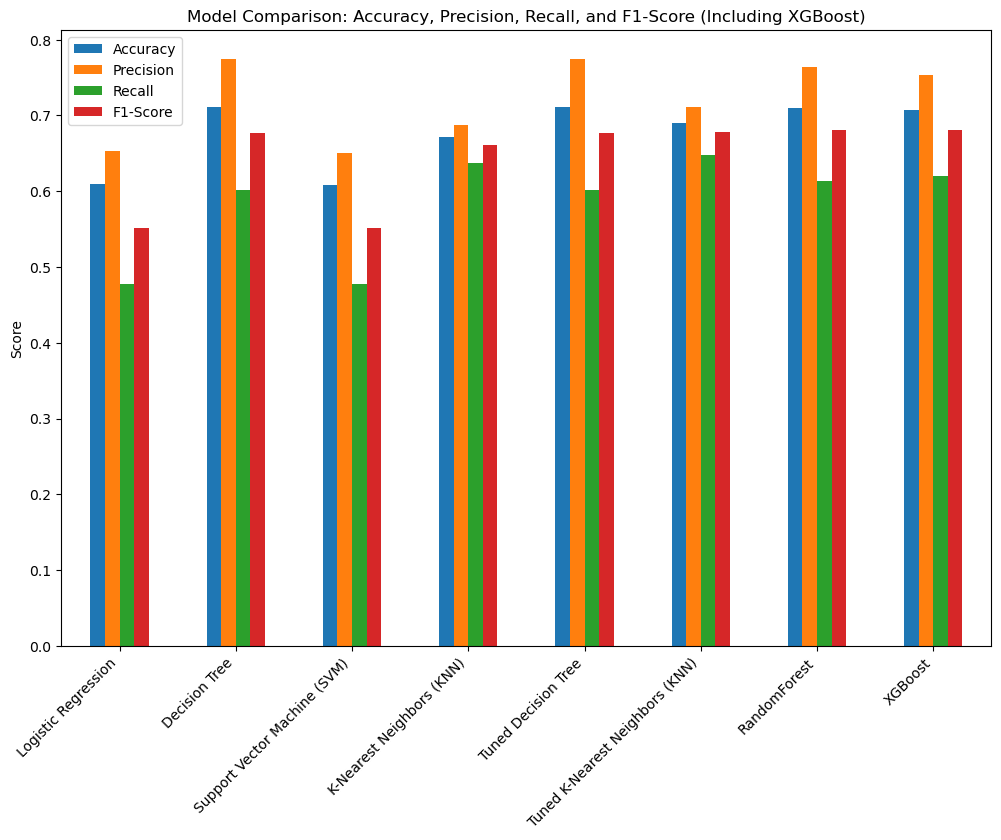

Images saved in folder: images/


In [8]:
# XGBoost Classifier: Evaluate and extract feature importances
print("\nXGBoost Classifier Results:")
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)  # Instantiate the XGBoost model

# Evaluate the model and get the trained model
xgboost_trained = evaluate_model(xgboost, "XGBoost")

# Ensure XGBoost metrics are calculated
accuracy_xgb = accuracy_score(y_test, xgboost_trained.predict(X_test))
precision_xgb = precision_score(y_test, xgboost_trained.predict(X_test))
recall_xgb = recall_score(y_test, xgboost_trained.predict(X_test))
f1_xgb = f1_score(y_test, xgboost_trained.predict(X_test))

# Ensure XGBoost metrics are added to model_metrics
model_metrics["XGBoost"] = {
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1-Score': f1_xgb
}

# Extract and display feature importances for XGBoost
xgboost_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgboost_trained.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nXGBoost Feature Importance:\n", xgboost_importance)

# Adding XGBoost metrics to the existing model comparison
metrics_df = pd.DataFrame(model_metrics).T  # Convert dictionary to DataFrame

# Plotting the updated metrics using seaborn
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Comparison: Accuracy, Precision, Recall, and F1-Score (Including XGBoost)')
plt.ylabel('Score')

# Rotate the x-axis labels and adjust alignment
plt.xticks(rotation=45, ha='right')

# Save and show the plot
plt.savefig(f"{save_path}model_comparison_with_xgboost.png")  # Save the updated metrics bar plot
plt.show()

print(f"Images saved in folder: {save_path}")
